In [1]:
%autoreload 2

In [2]:
import logging 
logging.basicConfig()
logging.getLogger("sparklink").setLevel(logging.WARNING)

In [3]:
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType
import pyspark.sql.functions as f

# WARNING:
# These config options are appropriate only if you're running Spark locally!!!
conf=SparkConf()
conf.set('spark.driver.memory', '8g')
conf.set("spark.sql.shuffle.partitions", "8") 

sc = SparkContext.getOrCreate(conf=conf)

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [4]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|London| hannah88@powers.com|    0|
|        2|    Julia | Taylor|2016-01-27|London| hannah88@powers.com|    0|
|        3|    Julia | Taylor|2015-10-29|  null|  hannah88opowersc@m|    0|
|        4|      oNah| Watson|2008-03-23|Bolton|matthew78@ballard...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



In [5]:
blocking_rules = [
    'l.first_name = r.first_name  and  l.surname = r.surname',
    'l.first_name = r.first_name  and  l.surname = r.surname',
    
    'l.first_name = r.first_name  and  l.dob = r.dob',
    'l.first_name = r.first_name  and  l.city = r.city',
    'l.dob = r.dob  and  l.city = r.city'
]

In [6]:
from sparklink.blocking import block_using_rules
df_comparison = block_using_rules(df, blocking_rules, spark=spark)
df_comparison.show(5)
# df_comparison = cartestian_block(df, df.columns, spark=spark)

+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+--------------------+--------------------+-------+-------+
|unique_id_l|unique_id_r|first_name_l|first_name_r|surname_l|surname_r|     dob_l|     dob_r|city_l|city_r|             email_l|             email_r|group_l|group_r|
+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+--------------------+--------------------+-------+-------+
|          6|         11|      Watson|      Watson|    Noah |    Noah |2008-03-23|2008-01-21|  null| Bolno|matthew78@ballard...|matthea78@bwllar-...|      1|      1|
|         38|         41|     Olivia |     Olivia |  Andrews|  Andrews|2009-01-23|2009-01-23|  null|London|hesterkurt@taylor...|hesterkurt@taylor...|      9|      9|
|         40|         42|     Olivia |     Olivia |  Andrews|  Andrews|2009-03-24|2009-01-23|London|London|hesterkurt@taylor...|hesterkuot@taylrr...|      9|      9|
|   

In [7]:
from sparklink.gammas import add_gammas

gamma_settings = {
    "first_name": {
        "levels": 3,
    },
    "surname": {
        "levels": 3
    },
    "dob": {
        "levels": 2
    },
    "city": {
        "levels": 2
    },
    "email": {
        "levels": 2
    }
}



df_gammas = add_gammas(df_comparison, gamma_settings, spark, include_orig_cols = True)
df_gammas.show(5)

+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+--------------------+--------------------+-------+-------+-------+-------+-------+
|unique_id_l|unique_id_r|first_name_l|first_name_r|surname_l|surname_r|     dob_l|     dob_r|city_l|city_r|             email_l|             email_r|gamma_0|gamma_1|gamma_2|gamma_3|gamma_4|
+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+--------------------+--------------------+-------+-------+-------+-------+-------+
|          6|         11|      Watson|      Watson|    Noah |    Noah |2008-03-23|2008-01-21|  null| Bolno|matthew78@ballard...|matthea78@bwllar-...|      2|      2|      0|     -1|      0|
|         38|         41|     Olivia |     Olivia |  Andrews|  Andrews|2009-01-23|2009-01-23|  null|London|hesterkurt@taylor...|hesterkurt@taylor...|      2|      2|      1|     -1|      1|
|         40|         42|     Olivia |     Olivia 

In [8]:
from sparklink.params import Params 
params = Params(gamma_settings, starting_lambda=0.5)

In [9]:
from sparklink.expectation_step import run_expectation_step
df_e= run_expectation_step(df_gammas, spark, params, compute_ll=True)

In [10]:
from sparklink.iterate import iterate
df_e = iterate(df_gammas, spark, params, num_iterations=2, compute_ll=True)

In [11]:
rdd  = df_e.limit(1).collect()
row_dict = rdd[0].asDict()
row_dict

{'unique_id_l': 6,
 'unique_id_r': 11,
 'first_name_l': 'Watson',
 'first_name_r': 'Watson',
 'surname_l': 'Noah ',
 'surname_r': 'Noah ',
 'dob_l': '2008-03-23',
 'dob_r': '2008-01-21',
 'city_l': None,
 'city_r': 'Bolno',
 'email_l': 'matthew78@ballard-mcdonald.net',
 'email_r': 'matthea78@bwllar-mcdonald.net',
 'gamma_0': 2,
 'gamma_1': 2,
 'gamma_2': 0,
 'gamma_3': -1,
 'gamma_4': 0,
 'prob_gamma_0_non_match': Decimal('0.747147023677825900'),
 'prob_gamma_0_match': Decimal('0.66516697406768800'),
 'prob_gamma_1_non_match': Decimal('0.2743709981441498'),
 'prob_gamma_1_match': Decimal('0.59921497106552120'),
 'prob_gamma_2_non_match': Decimal('0.5074800252914429'),
 'prob_gamma_2_match': Decimal('0.20798799395561218'),
 'prob_gamma_3_non_match': Decimal('1.00000000000000000'),
 'prob_gamma_3_match': Decimal('1.0000000000000000'),
 'prob_gamma_4_non_match': Decimal('0.93505102396011350'),
 'prob_gamma_4_match': Decimal('0.25905999541282654'),
 'match_probability': Decimal('0.485043')

In [12]:
from sparklink.intuition import intuition_report

r = intuition_report(row_dict, params)
print(r)


Initial probability of match (prior) = λ = 0.8101189732551575

Comparison of first_name.  Values are:
first_name_l: Watson
first_name_r: Watson
Comparison has 3 levels
𝛾 for this comparison = gamma_0 = 2
Amongst matches, P(𝛾 = 0.665166974067688):
Amongst non matches, P(𝛾 = 0.7471470236778259):
Adjustment factor = p1/(p1 + p2) = 0.470976691535663
New probability of match (updated belief): 0.7915938343548936

Comparison of surname.  Values are:
surname_l: Noah 
surname_r: Noah 
Comparison has 3 levels
𝛾 for this comparison = gamma_1 = 2
Amongst matches, P(𝛾 = 0.5992149710655212):
Amongst non matches, P(𝛾 = 0.2743709981441498):
Adjustment factor = p1/(p1 + p2) = 0.685925589679088
New probability of match (updated belief): 0.8924196765977039

Comparison of dob.  Values are:
dob_l: 2008-03-23
dob_r: 2008-01-21
Comparison has 2 levels
𝛾 for this comparison = gamma_2 = 0
Amongst matches, P(𝛾 = 0.20798799395561218):
Amongst non matches, P(𝛾 = 0.5074800252914429):
Adjustment factor = p1/(p1 + 

In [13]:
from sparklink.intuition import get_adjustment_factors
adjustment_factors = get_adjustment_factors(row_dict, params)
adjustment_factors

[{'gamma': 'gamma_0',
  'col_name': 'first_name',
  'value': 0.470976691535663,
  'normalised': -0.029023308464336983},
 {'gamma': 'gamma_1',
  'col_name': 'surname',
  'value': 0.685925589679088,
  'normalised': 0.185925589679088},
 {'gamma': 'gamma_2',
  'col_name': 'dob',
  'value': 0.29070201373150795,
  'normalised': -0.20929798626849205},
 {'gamma': 'gamma_3', 'col_name': 'city', 'value': 0.5, 'normalised': 0.0},
 {'gamma': 'gamma_4',
  'col_name': 'email',
  'value': 0.21694799830996112,
  'normalised': -0.28305200169003886}]

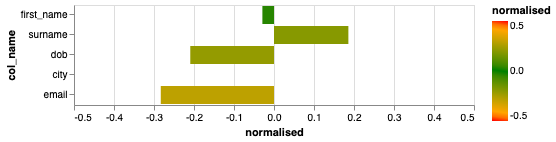

In [14]:
from sparklink.intuition import adjustment_factor_chart

adjustment_factor_chart(row_dict, params)

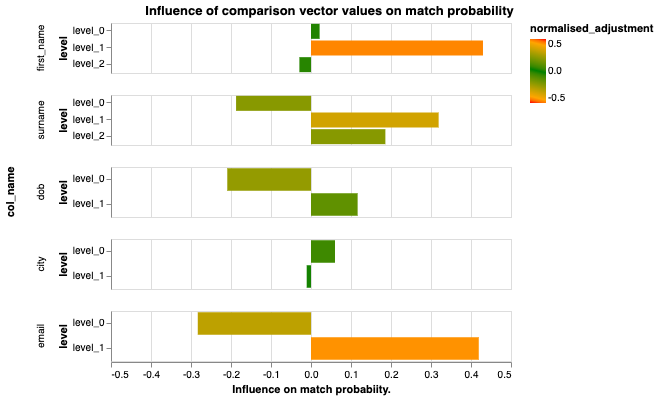

In [17]:
params.adjustment_factor_chart()

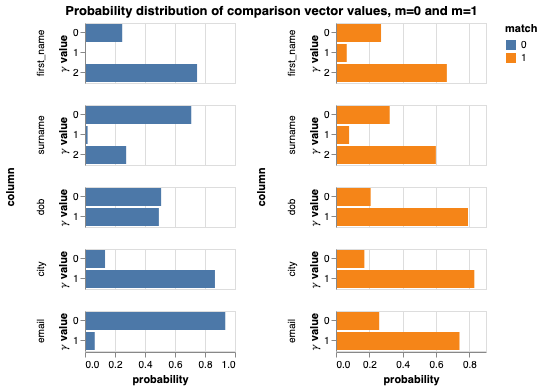

In [16]:
params.probability_distribution_chart()

data = []
# Want to compare the u and m probabilities
pi = gk = params.params["π"]
gk = list(pi.keys())

for g in gk:
    this_gamma = pi[g]
    for l in range(this_gamma["num_levels"]):
        row = {}
        level = f"level_{l}"
        row["level"] = level
        row["col_name"] = this_gamma["column_name"]
        row["m"] = this_gamma["prob_dist_match"][level]["probability"]
        row["u"] = this_gamma["prob_dist_non_match"][level]["probability"]
        row["adjustment"] = row["m"]/(row["m"] + row["u"])
        row["normalised_adjustment"] = row["adjustment"] - 0.5
        data.append(row)
data

In [90]:
chart_data = alt.Data(values=data)
chart = alt.Chart(chart_data).mark_bar().encode(
        x=alt.X('normalised_adjustment:Q', scale=alt.Scale(domain=[-0.5,0.5]), axis=alt.Axis(title='Influence on match probabiity.')),
        y=alt.Y('level:N'),
        row=alt.Row('col_name:N',  sort=alt.SortField("gamma")),
        color = alt.Color('normalised_adjustment:Q', scale=alt.Scale(domain=[-0.5, -0.4, 0, 0.4, 0.5], range=['red', 'orange', 'green', 'orange', 'red'])),
        tooltip = ['col_name:N', 'normalised_adjustment:Q']
        ).resolve_scale(
            y='independent'
        ).properties(title="Influence of comparison vector values on match probability"
).configure_title(
            anchor='middle'
        )
chart

In [85]:
d = chart.to_dict()
d["data"]["values"] = None
d

{'config': {'view': {'width': 400, 'height': 300},
  'mark': {'tooltip': None},
  'title': {'anchor': 'middle'}},
 'data': {'values': None},
 'mark': 'bar',
 'encoding': {'color': {'type': 'quantitative',
   'field': 'normalised_adjustment',
   'scale': {'domain': [-0.5, -0.4, 0, 0.4, 0.5],
    'range': ['red', 'orange', 'green', 'orange', 'red']}},
  'row': {'type': 'nominal', 'field': 'col_name', 'sort': {'field': 'gamma'}},
  'tooltip': [{'type': 'nominal', 'field': 'col_name'},
   {'type': 'quantitative', 'field': 'normalised_adjustment'}],
  'x': {'type': 'quantitative',
   'axis': {'title': 'Influence on match probabiity.'},
   'field': 'normalised_adjustment',
   'scale': {'domain': [-0.5, 0.5]}},
  'y': {'type': 'nominal', 'field': 'level'}},
 'height': 50,
 'resolve': {'scale': {'y': 'independent'}},
 'title': 'Influence of comparison vector values on match probability',
 '$schema': 'https://vega.github.io/schema/vega-lite/v3.4.0.json'}

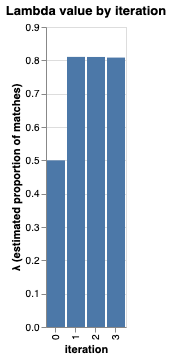

In [29]:
params.lambda_iteration_chart()

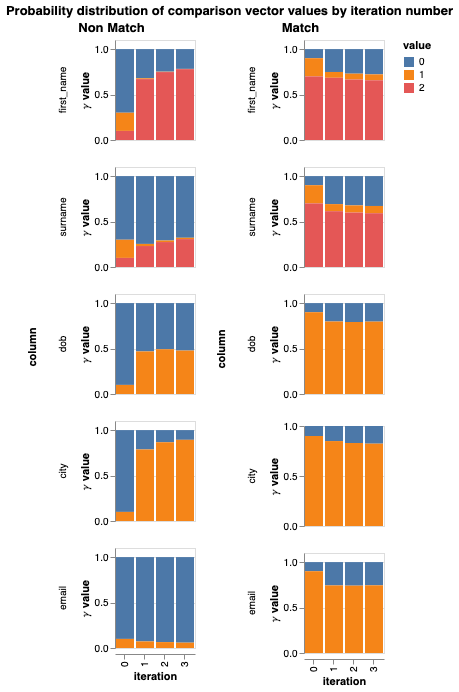

In [30]:
params.pi_iteration_chart()